## Imports

In [1]:
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist
#other
import pickle
import time

In [2]:
waveform_data=pd.read_parquet('../../../Data/padded_waveforms.parquet')

## Testing cropping with basic NN

In [3]:
cropped_data=['chonkers']
crop_value=100
while crop_value <= 1400:
    data.crop_waveforms(waveform_data,crop_value,'chonkers','front')
    data.crop_waveforms(waveform_data,crop_value,'chonkers','back')
    cropped_data.append('{}_front'.format(crop_value))
    cropped_data.append('{}_back'.format(crop_value))
    crop_value+=100
    

In [4]:
cropped_data

['chonkers',
 '100_front',
 '100_back',
 '200_front',
 '200_back',
 '300_front',
 '300_back',
 '400_front',
 '400_back',
 '500_front',
 '500_back',
 '600_front',
 '600_back',
 '700_front',
 '700_back',
 '800_front',
 '800_back',
 '900_front',
 '900_back',
 '1000_front',
 '1000_back',
 '1100_front',
 '1100_back',
 '1200_front',
 '1200_back',
 '1300_front',
 '1300_back',
 '1400_front',
 '1400_back']

In [ ]:
ML_data={name:data.make_ML_data(waveform_data,name) for name in cropped_data}

In [ ]:
results_dict={'accuracy':[],'execution_time':[]}
for crop in cropped_data:
    
    X_train, X_test, \
    y_train, y_test, \
    W_train, W_test, \
    runID_train, runID_test, \
    eventID_train, eventID_test = ML_data[crop]['data']
    
    CNN_model = keras.Sequential([
    keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu', input_shape=(ML_data[crop]['input_length'], 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(3, activation='softmax')
    ])
    
    CNN_model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    weighted_metrics=['accuracy'])
    
    st=time.time()
    hist_CNN_model = CNN_model.fit(X_train,y_train,epochs=20, validation_split=0.2, shuffle=True, sample_weight=W_train)
    et=time.time()
    
    results_dict['accuracy'].append(CNN_model.evaluate(X_test,y_test, sample_weight=W_test)) 
    results_dict['execution_time'].append(et-st)
   # with open('cropping_testing/CNN01/{}{}'.format(crop,'.pkl'),'wb') as f:
   #         pickle.dump(CNN_model, f)
    results=pd.DataFrame(results_dict)
    results.to_csv('cropping_testing/CNN01/results.csv')
    print(crop)

In [40]:
padding=np.arange(-800,700,100)
results_df=pd.read_csv('cropping_testing/CNN01/results.csv',index_col=0)
accuracies=[float(acc.strip('[]').split(', ')[2]) for acc in results_df['accuracy']]

results_df['execution_time'].to_numpy()

array([287.697469  , 274.16435623, 270.0587337 , 264.36277199,
       268.03377104, 252.31347823, 251.62576151, 230.56151628,
       227.57776284, 228.5053525 , 214.66666436, 203.53324342,
       203.51151824, 188.69821262, 188.09846139, 182.60103178,
       182.95844674, 165.60877848, 164.47645855, 151.42527652,
       150.62863135, 135.51266742, 156.41284037, 140.0101645 ,
       136.36245227, 112.31066036, 111.86540508, 101.30536008,
        99.42183328])

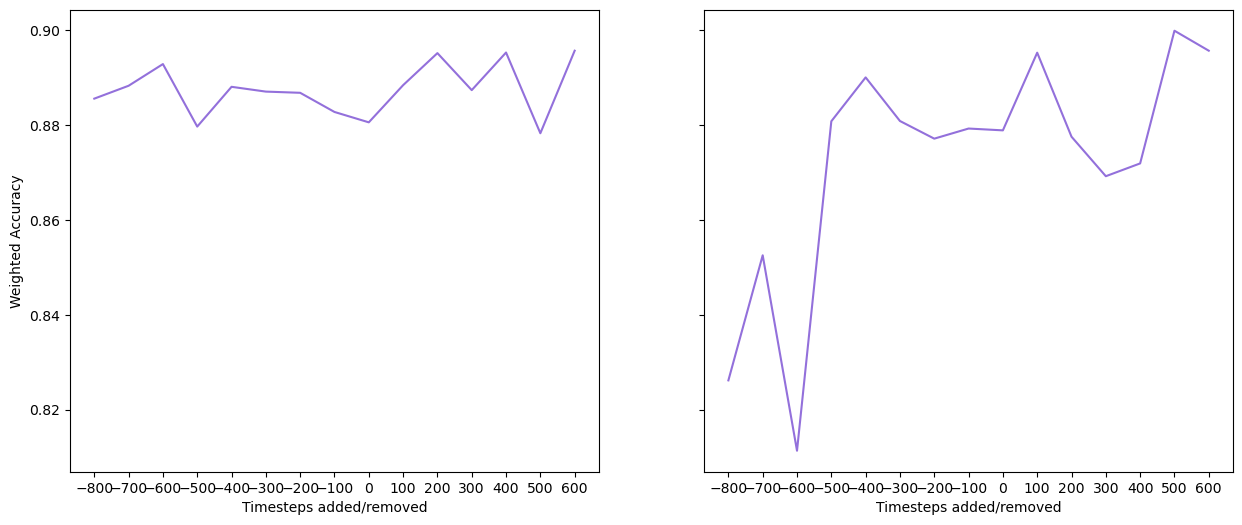

In [41]:
fig,ax=plt.subplots(1,2,figsize=(15,6),sharey=True)

ax[0].plot(padding,accuracies[::2][::-1],color='mediumpurple')
ax[0].set_xlabel('Timesteps added/removed')
ax[0].set_xticks(padding)
ax[0].set_ylabel('Weighted Accuracy')
#ax[0].grid()
#ax[0].set_ylim(top=1.00)

#ax1=ax[0].twinx()
#ax1.plot(padding,results_df['execution_time'].to_numpy()[::2][::-1],color='orange')
#ax1.set_xlabel('Timesteps added/removed')
#ax1.set_xticks(padding)
#ax1.set_ylabel('Execution Time/s')

ax[1].plot(padding,accuracies[1::2][::-1]+[accuracies[0]],color='mediumpurple')
ax[1].set_xlabel('Timesteps added/removed')
ax[1].set_xticks(padding)
# ax[1].grid()
# ax[1].set_ylabel('Weighted Accuracy')
# ax[1].set_ylim(top=1.0)

# ax2=ax[1].twinx()
# ax2.plot(padding,results_df['execution_time'].to_numpy()[1::2][::-1]+[results_df['execution_time'].to_numpy()[0]],color='orange')
# ax2.set_xlabel('Timesteps added/removed')
# ax2.set_xticks(padding)
# ax2.set_ylabel('Execution Time/s')